In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import ngboost as ngb
from ngboost import NGBoost
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


data = pd.read_csv("data.csv")

C:\Users\DELL\AppData\Local\Temp\ipykernel_18124\164789893.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       1811 non-null   object 
 1   subcategory    1252 non-null   object 
 2   product_brand  1472 non-null   object 
 3   product_name   1811 non-null   object 
 4   ratings        1642 non-null   float64
 5   reviews        1642 non-null   object 
 6   price          1670 non-null   object 
 7   Date           1811 non-null   object 
dtypes: float64(1), object(7)
memory usage: 113.3+ KB


In [3]:
data.head()

,category,subcategory,product_brand,product_name,ratings,reviews,price,Date
0,Women's clothing,Maternity,AV2,Women's Rayon A-Line Maternity Kurta,3.9,"1,418",999,07-09-2023
1,Sunglasses & frames,Blue Cut glasses,NaN,Aferelle® Silvercare Premium Blue Ray Cut Blue...,3.9,"2,017",449,01-05-2023
2,Cameras & Photography,Studio Lighting Equipments,NaN,Powerpak SL-4B | 8 x LED Bulb Studio Light Kit...,3.7,17,NaN,13-06-2023
3,Footwear,Kids footwear,Red Tape,"Women’s Sports Walking Shoes - Arch Support, D...",4.3,760,"1,359",21-06-2023
4,Men's clothing,NaN,Peter England,"Men's Cotton Hankderchief (Pack of 3) - Green,...",3.8,17,289,15-03-2023


In [4]:
data.isna().sum()

category           0
subcategory      559
product_brand    339
product_name       0
ratings          169
reviews          169
price            141
Date               0
dtype: int64

In [5]:
# replacing commas and converting object to float
data['price'] = data['price'].replace({',' : ''}, regex=True)
data['reviews'] = data['reviews'].replace({',' : ''}, regex=True)

data['price'] = pd.to_numeric(data['price'])
data['reviews'] = pd.to_numeric(data['reviews'])

In [6]:
# Label encoding for categorical columns
le = LabelEncoder()

data['category'] = le.fit_transform(data['category'])
data['subcategory'] = le.fit_transform(data['subcategory'])
data['product_brand'] = le.fit_transform(data['product_brand'])
data['product_name'] = le.fit_transform(data['product_name'])

In [7]:
data.head()

,category,subcategory,product_brand,product_name,ratings,reviews,price,Date
0,11,21,14,1339,3.9,1418.0,999.0,07-09-2023
1,8,6,383,56,3.9,2017.0,449.0,01-05-2023
2,2,36,383,793,3.7,17.0,NaN,13-06-2023
3,3,17,260,1446,4.3,760.0,1359.0,21-06-2023
4,7,50,234,601,3.8,17.0,289.0,15-03-2023


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       1811 non-null   int32  
 1   subcategory    1811 non-null   int32  
 2   product_brand  1811 non-null   int32  
 3   product_name   1811 non-null   int32  
 4   ratings        1642 non-null   float64
 5   reviews        1642 non-null   float64
 6   price          1670 non-null   float64
 7   Date           1811 non-null   object 
dtypes: float64(3), int32(4), object(1)
memory usage: 85.0+ KB


In [9]:
data.isna().sum()

category           0
subcategory        0
product_brand      0
product_name       0
ratings          169
reviews          169
price            141
Date               0
dtype: int64

In [10]:
# dealing with null values
mean_price_1 = data['ratings'].mean()
data['ratings'] = data['ratings'].fillna(mean_price_1)

mean_price_2 = data['reviews'].mean()
data['reviews'] = data['reviews'].fillna(mean_price_2)

mean_price_3 = data['price'].mean()
rounded_mean_price_3 = round(mean_price_3, 2)
data['price'] = data['price'].fillna(rounded_mean_price_3)
print(rounded_mean_price_3)

1690.57


In [11]:
data.isna().sum()

category         0
subcategory      0
product_brand    0
product_name     0
ratings          0
reviews          0
price            0
Date             0
dtype: int64

In [12]:
data.head()

,category,subcategory,product_brand,product_name,ratings,reviews,price,Date
0,11,21,14,1339,3.9,1418.0,999.00,07-09-2023
1,8,6,383,56,3.9,2017.0,449.00,01-05-2023
2,2,36,383,793,3.7,17.0,1690.57,13-06-2023
3,3,17,260,1446,4.3,760.0,1359.00,21-06-2023
4,7,50,234,601,3.8,17.0,289.00,15-03-2023


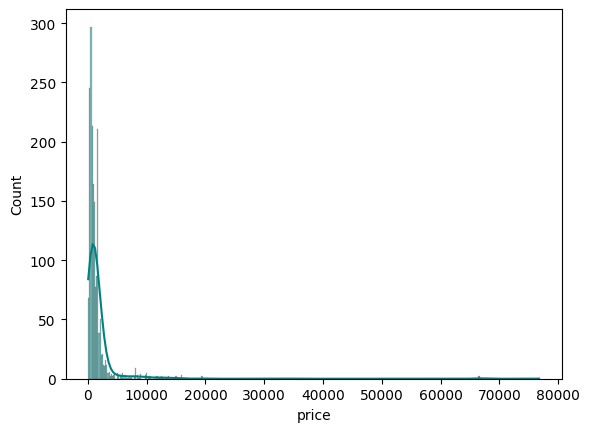

In [13]:
ax = sns.histplot(data['price'], kde=True, color='teal')
plt.show()

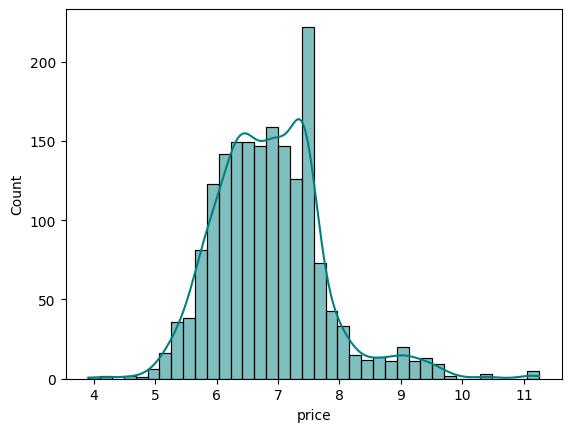

In [14]:
target = np.log1p(data['price'])
sns.histplot(target, kde=True, color='teal')
plt.show()

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
category,1811.0,6.384318,3.299633,0.0,4.0,7.000000,8.00,11.0
subcategory,1811.0,31.107675,17.711095,0.0,14.0,34.000000,50.00,50.0
product_brand,1811.0,232.429597,122.630235,0.0,125.5,239.000000,349.00,383.0
product_name,1811.0,763.813363,428.796036,0.0,412.5,742.000000,1145.00,1504.0
ratings,1811.0,4.044336,0.456138,1.0,3.9,4.044336,4.20,5.0
reviews,1811.0,3892.999391,12230.187662,1.0,47.0,499.000000,3669.50,162054.0
price,1811.0,1690.568399,4264.516023,49.0,515.5,949.000000,1690.57,76751.0


In [16]:
# adding seasonality features
data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y")

data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_of_year'] = data['Date'].dt.dayofyear
data['week'] = data['Date'].dt.isocalendar().week
data['quarter'] = data['Date'].dt.quarter
data.head()

,category,subcategory,product_brand,product_name,ratings,reviews,price,Date,month,day,day_of_year,week,quarter
0,11,21,14,1339,3.9,1418.0,999.00,2023-09-07,9,7,250,36,3
1,8,6,383,56,3.9,2017.0,449.00,2023-05-01,5,1,121,18,2
2,2,36,383,793,3.7,17.0,1690.57,2023-06-13,6,13,164,24,2
3,3,17,260,1446,4.3,760.0,1359.00,2023-06-21,6,21,172,25,2
4,7,50,234,601,3.8,17.0,289.00,2023-03-15,3,15,74,11,1


In [17]:
duplicates = data.duplicated()

# Print the number of duplicates
print("Number of duplicates: ", duplicates.sum())

# Print the rows that are duplicates
print(data[duplicates])
data.drop_duplicates()

Number of duplicates:  1
      category  subcategory  product_brand  product_name   ratings  \
1798        11           21            209          1348  4.044336   

          reviews   price       Date  month  day  day_of_year  week  quarter  
1798  3892.999391  1049.0 2023-08-31      8   31          243    35        3  


,category,subcategory,product_brand,product_name,ratings,reviews,price,Date,month,day,day_of_year,week,quarter
0,11,21,14,1339,3.9,1418.0,999.00,2023-09-07,9,7,250,36,3
1,8,6,383,56,3.9,2017.0,449.00,2023-05-01,5,1,121,18,2
2,2,36,383,793,3.7,17.0,1690.57,2023-06-13,6,13,164,24,2
3,3,17,260,1446,4.3,760.0,1359.00,2023-06-21,6,21,172,25,2
4,7,50,234,601,3.8,17.0,289.00,2023-03-15,3,15,74,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,4,50,11,500,3.8,316.0,449.00,2023-02-02,2,2,33,5,1
1807,2,36,383,465,3.8,327.0,1690.57,2023-01-11,1,11,11,2,1
1808,0,10,383,885,4.3,35675.0,1690.57,2023-11-17,11,17,321,46,4
1809,8,6,383,298,4.1,516.0,474.00,2023-06-29,6,29,180,26,2


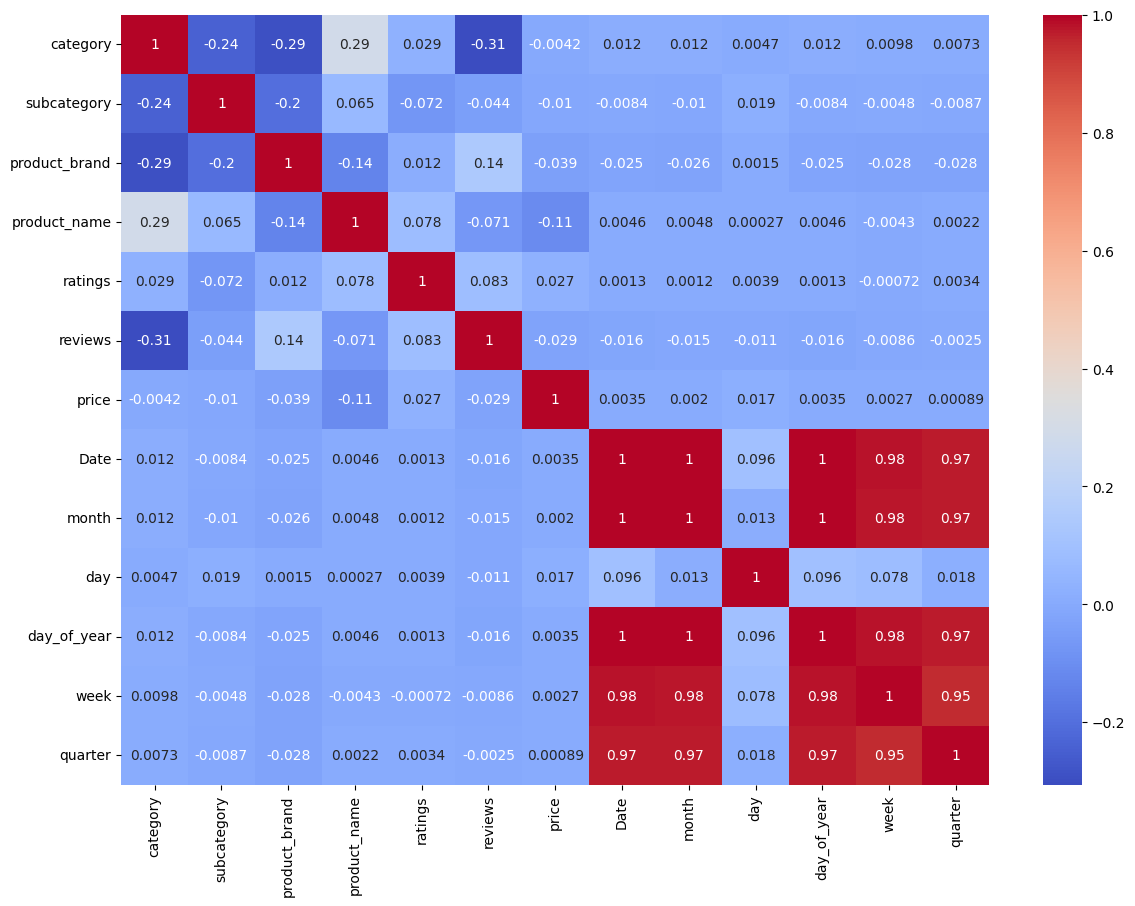

In [18]:
corr_matrix = data.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.xticks(rotation=90)
plt.show()

In [19]:
# XGBoost Model

X = data.drop(columns=['price', 'Date'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train, y_train)


xgb_pred = xgb_model.predict(X_test)

In [20]:
mse_1 = mean_squared_error(y_test, xgb_pred)
print("Root mean squared error: ", np.sqrt(mse_1))

r_squared1 = r2_score(y_test, xgb_pred)
print("R-squared score :", r_squared1) 

mae1 = mean_absolute_error(y_test, xgb_pred)
print("Mean absolute error:", mae1)

Root mean squared error:  5272.456486457367
R-squared score : -0.020903958938668366
Mean absolute error: 1257.8995260464849


In [21]:
# NGBoost Model

# Define the NgBoost model

ngb_model = ngb.NGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    random_state=42
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=ngb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", grid_search.best_params_)
# print("Best mean squared error: ", np.sqrt(np.abs(grid_search.best_score_)))

# Fit the NgBoost model with the best hyperparameters to the training data
ngb_best = grid_search.best_estimator_

ngb_best.fit(X_train, y_train)

# Evaluate the model on the test data
ngb_pred = ngb_best.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 0] loss=9.7100 val_loss=0.0000 scale=1.0000 norm=1345.7653
Best hyperparameters:  {'learning_rate': 0.001, 'n_estimators': 100}
[iter 0] loss=9.7100 val_loss=0.0000 scale=1.0000 norm=1345.7653


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


In [22]:
mse_2 = mean_squared_error(y_test, ngb_pred)
print("Root mean squared error: ", np.sqrt(mse_2))

r_squared2 = r2_score(y_test,ngb_pred)
print("R-squared score :", r_squared2) 

mae2 = mean_absolute_error(y_test, ngb_pred)
print("Mean Absolute error:", mae2)

Root mean squared error:  5110.44194433864
R-squared score : 0.040873705150730744
Mean Absolute error: 1441.534160436613


In [ ]:
#XGBOOST ON NGBOOST
# Train NGBoost
ngb = NGBRegressor()
ngb.fit(X_train, y_train, early_stopping_rounds=10)

# Get predictions from NGBoost
ngb_train_pred = ngb.predict(X_train)
ngb_test_pred = ngb.predict(X_test)

# Train XGBoost on NGBoost predictions
xgb = XGBRegressor()
xgb.fit(np.hstack((X_train, ngb_train_pred.reshape(-1, 1))), y_train)

# Define hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.001]
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create XGBoost model with hyperparameter grid
xgb_grid = GridSearchCV(xgb, param_grid_xgb, cv=kfold, scoring='neg_mean_squared_error')
xgb_grid.fit(np.hstack((X_train, ngb_train_pred.reshape(-1, 1))), y_train, eval_set=[(np.hstack((X_test, ngb_test_pred.reshape(-1, 1))), y_test)], early_stopping_rounds=10, verbose=False)

# Print best hyperparameters
print('Best hyperparameters for XGBoost on NGBoost:', xgb_grid.best_params_)

# Get predictions from XGBoost on NGBoost predictions
xg_on_ng_pred = xgb_grid.predict(np.hstack((X_test, ngb_test_pred.reshape(-1,1))))

In [ ]:
mse_3 = mean_squared_error(y_test, xg_on_ng_pred)
print("Root mean squared error: ", np.sqrt(mse_3))

r_squared3 = r2_score(y_test,xg_on_ng_pred)
print("R-squared score :", r_squared3) 

mae3 = mean_absolute_error(y_test, xg_on_ng_pred)
print("Mean absolute error:", mae3)

Root mean squared error:  4478.624561766276
R-squared score : 0.2633720478044157
Mean absolute error: 1015.8745976555775


In [ ]:
#NGBOOST ON XGBOOST
# Train XGBoost
xgb = XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True, early_stopping_rounds=5)

# Get predictions from XGBoost
xgb_train_pred = xgb.predict(X_train)
xgb_test_pred = xgb.predict(X_test)

# Train NGBoost on XGBoost predictions
ngb = NGBRegressor()

ngb.fit(np.hstack((X_train, xgb_train_pred.reshape(-1, 1))), y_train, early_stopping_rounds=5)

# Get predictions from NGBoost on XGBoost predictions
ng_on_xg_pred = ngb.predict(np.hstack((X_test, xgb_test_pred.reshape(-1,1))))

In [ ]:
mse_4 = mean_squared_error(y_test, ng_on_xg_pred)
print("Root mean squared error: ", np.sqrt(mse_4))

r_squared4 = r2_score(y_test,ng_on_xg_pred)
print("R-squared score :", r_squared4) 

mae4 = mean_absolute_error(y_test, ng_on_xg_pred)
print("Accuracy:", mae4)

Root mean squared error:  5550.418581202701
R-squared score : -0.13138483280876656
Accuracy: 1252.892691377288


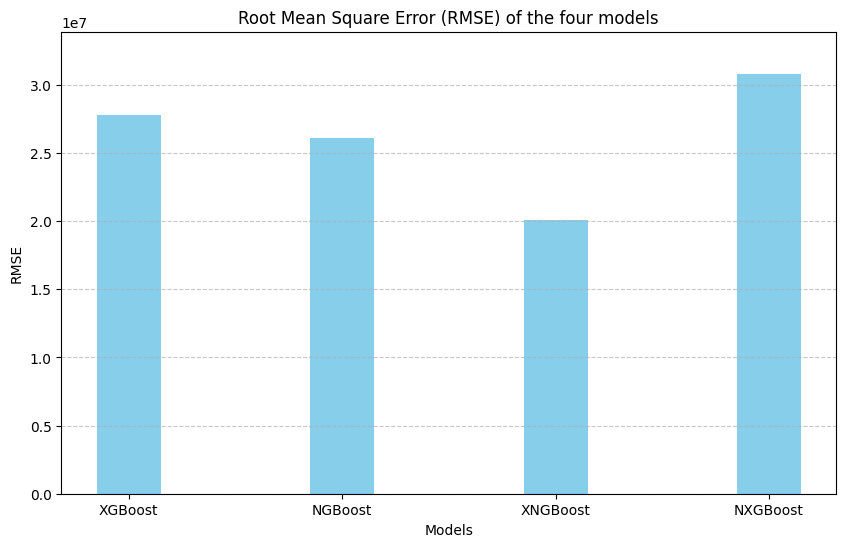

In [ ]:
model_names = ['XGBoost', 'NGBoost', 'XNGBoost', 'NXGBoost']
rmse_values = [mse_1, mse_2, mse_3, mse_4]

plt.figure(figsize=(10, 6))
index = range(len(model_names))
plt.bar(index, rmse_values, color='skyblue', width=0.3)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Root Mean Square Error (RMSE) of the four models')
plt.xticks(index, model_names)
plt.ylim(0, max(rmse_values) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

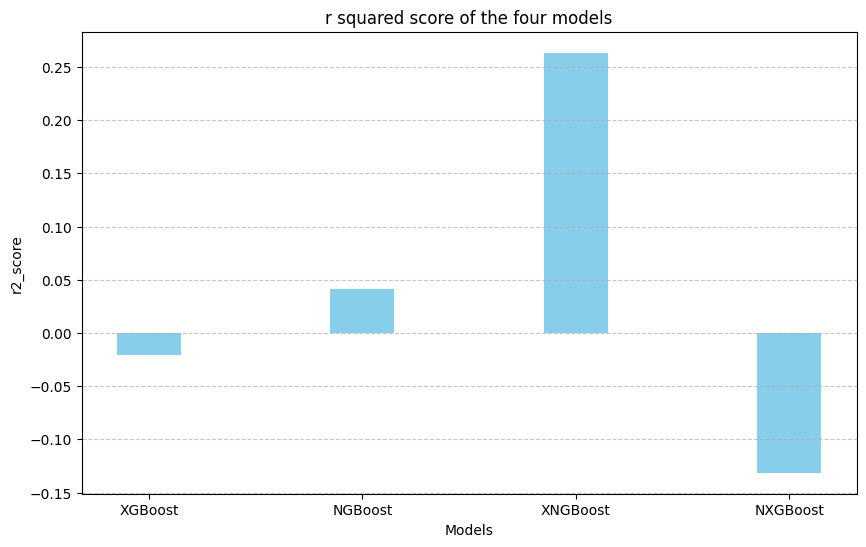

In [ ]:
model_names = ['XGBoost', 'NGBoost', 'XNGBoost', 'NXGBoost']
r2score_values = [r_squared1, r_squared2, r_squared3, r_squared4]

plt.figure(figsize=(10, 6))
index = range(len(model_names))
plt.bar(index, r2score_values, color='skyblue', width=0.3)
plt.xlabel('Models')
plt.ylabel('r2_score')
plt.title('r squared score of the four models')
plt.xticks(index, model_names)
#plt.ylim(0, max(r2score_values) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

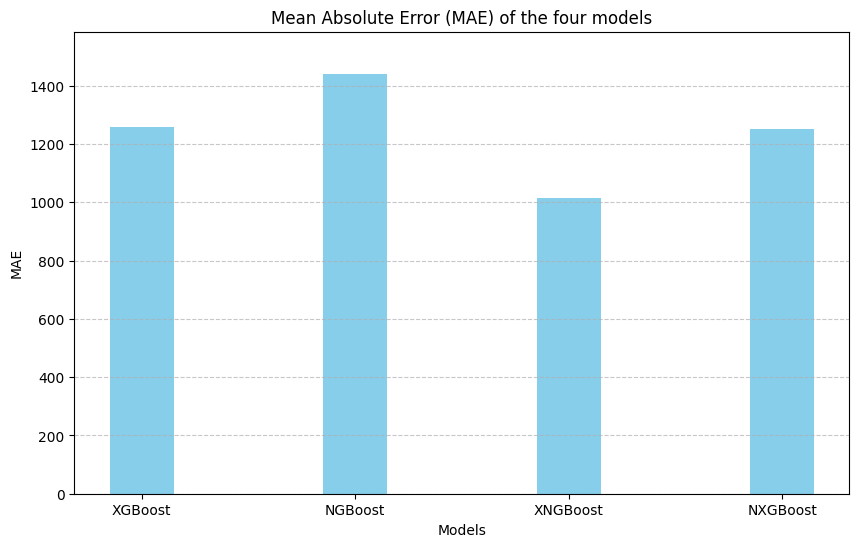

In [ ]:
model_names = ['XGBoost', 'NGBoost', 'XNGBoost', 'NXGBoost']
mae_values = [mae1, mae2, mae3, mae4]

plt.figure(figsize=(10, 6))
index = range(len(model_names))
plt.bar(index, mae_values, color='skyblue', width=0.3)
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) of the four models')
plt.xticks(index, model_names)
plt.ylim(0, max(mae_values) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()